# Packages Import

In [0]:
# !pip install lime
# !pip install contractions
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import pandas as pd
import numpy as np
import os
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer

import pickle
import matplotlib.pyplot as plt
import itertools
from functools import partial
from itertools import product

from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

from gensim import corpora
from gensim import corpora
from gensim.similarities.docsim import Similarity
from gensim import corpora, models, similarities

In [0]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Data Loading
- Load and read the data in google cloud 
- Link is the sharable link in google drive

In [0]:
def read_csv(uploaded, name):
  from io import StringIO
  s=str(uploaded[name],'utf-8')
  data = StringIO(s) 
  df=pd.read_csv(data)
  return df

In [57]:
link = "https://drive.google.com/open?id=1cXu9-KprFIUmPsFWT1TRR3UTc-6A07MI"
_, drive_id = link.split('=')
downloaded = drive.CreateFile({'id': drive_id})
downloaded.GetContentFile('./sample.csv')
reviews = pd.read_csv('./sample.csv')
reviews = reviews[reviews.business_id!='0']
print(len(reviews))
reviews.head()

1151349


,user_id,business_id,rating,date,reviews,useful,funny,cool
0,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,2016-05-07 01:21:02,Tracy dessert had a big name in Hong Kong and ...,5.0,4.0,5.0
1,5JVY32_bmTBfIGpCCsnAfw,Mem13A3C202RzT53npn4NA,5.0,2017-05-13 10:41:43,If you are looking for the best pierogies in P...,9.0,6.0,9.0
2,3CJUJILq7CLHk_9OrvpvQg,I4Nr-MVc26qWr08-S3Q1ow,4.0,2016-01-17 05:26:22,The food is always good and the prices are rea...,0.0,0.0,0.0
3,jAVtSgE5L-Dt6_I5FIiVGA,EIL41z-hvVCeYHqfA9PyWQ,5.0,2017-09-20 15:23:35,Flat out fantastic! Have been here twice and ...,1.0,0.0,1.0
4,XPZVfP7DQCSL3Nb9t2vxsA,1HD5iUUfVJDbfEBIn9yVhw,5.0,2017-03-15 02:02:13,Yes... the Boba Tea explosion is in full force...,11.0,8.0,11.0


In [58]:
link_biz = 'https://drive.google.com/open?id=1NyrsPerkXKKmu3woovR3hFob_o2FKAT6'
_, drive_id_biz = link_biz.split('=')
downloaded_biz = drive.CreateFile({'id': drive_id_biz})
downloaded_biz.GetContentFile('./business.json')
business = pd.read_json('./business.json', lines=True)
print(business.shape)
business.head()

(192609, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [59]:
df_btext = reviews.groupby('business_id')['reviews']\
                  .apply(lambda x: x.str.cat())\
                  .reset_index()

sample = df_btext.sample(n=1000, replace=False, random_state=42)\
                 .reset_index()\
                 .drop(columns=['index'])
sample

,business_id,reviews
0,i1fBaC-wRmrZ7K8LtZNCFQ,I love this cleaners!! The staff is amazing an...
1,OwzqgrpKs9nojICU65hhzg,Cheese pizza slice. Ok not great. If your hung...
2,JRRvAkG4c_VeRX1SB7oMxQ,Finding your way here is a bit of a challenge....
3,7Q0W1a1jxxTOduu5cncFyg,Percida is a gem! I contacted her thinking she...
4,_3KLfU6lmMBgcQQ2T-E6AA,I was initially a bit intimidated cause you ne...
...,...,...
995,qm_65wDFRSgPaI6nLB9kfw,"They have very bad customer service, they take..."
996,Gk3YpwgiQf47YKkAUZtQTw,"Wow, I was really amazed when I walked in. It ..."
997,js_Xv7OjruKdUWtg8VfRiQ,"havent been to a dentist in years, i need a LO..."
998,7IwvxPCKrxP6hbwHAFlm3Q,If I could give zero stars I would. I came her...


In [0]:
all_text=''
all_snippets = sample['reviews'].values
for snippet in all_snippets:
    all_text+=snippet

In [0]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=6000,height=6000).generate(all_text)

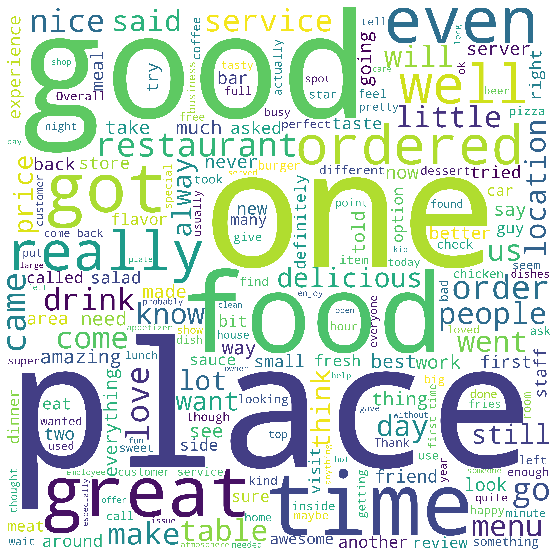

In [154]:
fig=plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Text Preprocessing
- transform the text into standardized format: stopwords removal, lemmatization, stemming
- to accelerate the processing time, we randomly selected 1,000 businesses 
- filter the user reviews based on the availability of these businesses

In [0]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [61]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

def get_processed(sample):
  processed = pd.DataFrame(data=[],columns = ['business_id', 'reviews'])
  new_texts = []

  for i in range(0, len(sample)):
    business_id = sample['business_id'].iloc[i]
    words = nltk.word_tokenize(sample['reviews'].iloc[i])
    text = ' '.join(normalize_lemmatize(words))
    dfnew = pd.DataFrame([[business_id, text]], columns=['business_id', 'reviews'])
    new_texts.append(text)
    processed = processed.append(dfnew,ignore_index = True)
  
  return processed

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
processed = get_processed(sample)
processed.head()

,business_id,reviews
0,i1fBaC-wRmrZ7K8LtZNCFQ,love cleaner staff amaz facil clean profession...
1,OwzqgrpKs9nojICU65hhzg,chees pizza slice ok great hungri good enough ...
2,JRRvAkG4c_VeRX1SB7oMxQ,find way bite challeng suppos come often get h...
3,7Q0W1a1jxxTOduu5cncFyg,percida gem contact think would turn due lastm...
4,_3KLfU6lmMBgcQQ2T-E6AA,initi bite intimid caus need get buzz enter st...


# Cosine Similarity

$similarity = cosine(tfidf_{tweet}, tfidf_{cluster}) * \exp(\frac{-(T_{tweet} - T_{cluster})^2}{2\sigma^2})$

In [0]:
def get_cos_sim_matrix(processed):
  tfidf = TfidfVectorizer(stop_words='english')
  processed['reviews'] = processed['reviews'].fillna('')
  tfidf_matrix = tfidf.fit_transform(processed['reviews'])
  svd = TruncatedSVD(n_components=10, random_state=42)
  tfidf_truncated = svd.fit_transform(tfidf_matrix) 
  cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
  return cosine_sim

In [64]:
cosine_sim = get_cos_sim_matrix(processed)
cosine_sim.shape

(1000, 1000)

In [0]:
def get_recommendation_cos(processed, reviews, business_id, user_id, cosine_sim, k):
  df_sim = pd.DataFrame(cosine_sim, index=processed['business_id'], columns=processed['business_id'])
  user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
  df_row = df_sim.loc[df_sim.index==business_id]
  df_user = df_row[user_bids]
  results = list(zip(list(df_user.columns), list(df_user.values[0])))
  results_ordered = sorted(results, key=lambda x: x[1], reverse=True)
  results_topk = np.array(results_ordered[1:k+1])
  return results_topk[:,0]

def predict_rating(reviews, user_id, business_ids):
  scores = []
  for bid in business_ids:
    score = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==bid)]['rating']
    scores.append(score.values[0])
  return np.mean(scores)

def get_results_cos(processed,reviews,business,business_id,user_id,cosine_sim,k):
  actual = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==business_id)]['rating'].values[0]
  business_ids = get_recommendation_cos(processed,reviews,business_id,user_id,cosine_sim,k)
  prediction = predict_rating(reviews, user_id, business_ids)
  return actual, prediction

In [66]:
def get_review_processed(processed, reviews):
  reviews_processed = reviews.loc[reviews.business_id.isin(processed.business_id)]\
                           .reset_index()\
                           .drop(columns=['index'])
  return reviews_processed

reviews_processed = get_review_processed(processed, reviews)
reviews_processed.head()

,user_id,business_id,rating,date,reviews,useful,funny,cool
0,J3ucveGKKJDvtuCNnb_x0g,ytYP2UXkRow2L3emGp469w,4.0,2017-07-18 18:38:20,We came here one evening. We were starving an...,1.0,0.0,1.0
1,KiUBp6hGhFTs8wOIbP0tcg,WSAN2er3DhaZ8ybNStxCbw,4.0,2017-01-02 05:17:20,This is one of the last of a Pittsburgh classi...,4.0,0.0,3.0
2,PwFs1cC2QTXZZ2ee6CPTAw,9uUfqLdfV-1BFAJQYEyEYA,3.0,2016-10-26 16:43:53,"The place is absolutely gorgeous, yes. Nothin...",4.0,1.0,1.0
3,XxyyTYuL7KrrBFg8a14bEA,jX9DocoiY4Bo9EUkaTSqvg,2.0,2017-01-14 20:55:39,"If you are in a hurry, DO NOT use the online p...",3.0,2.0,1.0
4,dJ_AhP3TpmZblvuLgz_r5Q,NvgwuOshnRvK5qR4piZmew,5.0,2016-06-11 21:44:59,This is close by where we live and its ao conv...,0.0,0.0,0.0


In [0]:
def get_coverage(processed,reviews,business,cosine_sim,k):
  reviews_processed = get_review_processed(processed, reviews)
  uid_sample = reviews_processed['user_id'].values
  bid_sample = reviews_processed['business_id'].values

  all_bids = reviews_processed['business_id'].unique()
  pred_bids = []

  for i in range(len(reviews_processed)):
    try:
      business_ids = get_recommendation_cos(processed,
                                            reviews_processed,
                                            bid_sample[i],
                                            uid_sample[i],
                                            cosine_sim,
                                            k)
      pred_bids += list(business_ids)
    except:
      next
  pred_bids = np.array(list(set(pred_bids)))
  return len(pred_bids)/len(all_bids)

In [0]:
uid_sample = reviews_processed['user_id'].values
bid_sample = reviews_processed['business_id'].values
predictions_cos = []
actual_cos = []
for i in range(len(reviews_processed)):
  try:
    act, pred = get_results_cos(processed, 
                                reviews_processed, 
                                business, 
                                bid_sample[i], 
                                uid_sample[i], 
                                cosine_sim, 
                                5)
    predictions_cos.append(pred)
    actual_cos.append(act)
  except:
    next

In [72]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

RMSE: 1.356364928730251, MAE: 0.852681208816178


In [208]:
cov_cos = get_coverage(processed,reviews,business,cosine_sim,5)
print(f'coverage: {cov_cos}')

coverage: 0.59


# LSI Model
- Latent Semantic Analysis is a technique in natural language processing 
- LSA tries to analyze the relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms
- Different from the traditional approach, out of all the preprocessed documents in the sample set, we pre-select the texts which the user has already rated and further process the texts into a corpus 
- We then compute the similarity score from the LSI model against the corpus and rank the documents inside the corpus which consists of the texts the user has previously rated. 
- This is an alternative to cosine similarity for comparing the similarity between different documents
- We need to make assumptions on the number of topics for the ensemble of documents, which is associated with the set of concepts related to all the documents
- The next step would be to learn the optimal number of topics, which is initially set as 100

In [0]:
def get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics):
  user_bids = reviews[reviews['user_id']==user_id]['business_id'].values
  processed_user = processed.loc[processed.business_id.isin(user_bids)]
  documents = list(processed_user['reviews'].values)
  texts = [[word for word in document.split(' ')] for document in documents]
  dictionary = corpora.Dictionary(texts)
  corpus = [dictionary.doc2bow(text) for text in texts] 

  lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=n_topics)
  doc = processed['reviews'].loc[processed.business_id==business_id].values[0]
  vec_bow = dictionary.doc2bow(doc.lower().split())
  vec_lsi = lsi[vec_bow]
  index = similarities.MatrixSimilarity(lsi[corpus])
  sims = list(index[vec_lsi])
  results = list(zip(user_bids, sims))
  results_ordered = np.array(sorted(results, key=lambda x: x[1], reverse=True))
  results_topk = results_ordered[:5]

  return results_topk[:,0]

def get_results_lsi(processed,reviews,business,business_id,user_id,k,n_topics):
  actual = reviews.loc[(reviews.user_id==user_id) & (reviews.business_id==business_id)]['rating'].values[0]
  business_ids = get_recommendation_lsi(processed,reviews,business_id,user_id,k,n_topics)
  prediction = predict_rating(reviews, user_id, business_ids)
  return actual, prediction

def get_coverage_lsi(processed,reviews,business,n_topics):
  reviews_processed = get_review_processed(processed, reviews)
  uid_sample = reviews_processed['user_id'].values
  bid_sample = reviews_processed['business_id'].values

  all_bids = reviews_processed['business_id'].unique()
  pred_bids = []

  for i in range(len(reviews_processed)):
    try:
      business_ids = get_recommendation_lsi(processed,
                                            reviews_processed,
                                            bid_sample[i],
                                            uid_sample[i],
                                            5,
                                            n_topics)
      pred_bids += list(business_ids)
    except:
      next
  pred_bids = np.array(list(set(pred_bids)))
  return len(pred_bids)/len(all_bids)

In [82]:
predictions_lsi = []
actual_lsi = []
for i in range(len(reviews_processed)):
  try:
    act, pred = get_results_lsi(processed, 
                                reviews_processed, 
                                business, 
                                bid_sample[i], 
                                uid_sample[i], 
                                5,
                                100)
    predictions_lsi.append(pred)
    actual_lsi.append(act)
  except:
    next

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [83]:
rmse_lsi = mean_squared_error(predictions_lsi, actual_lsi)**0.5
mae_lsi = mean_absolute_error(predictions_lsi, actual_lsi)
print(f'RMSE: {rmse_lsi}, MAE: {mae_lsi}')

RMSE: 0.44605640676934855, MAE: 0.16084192630372918


In [212]:
cov_lsi = get_coverage_lsi(processed,reviews,business,100)
print(f'coverage: {cov_lsi}')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


coverage: 1.0


# Mixture Model
- To improve the model, we can add additional similarity matrix on top of the cosine similarity matrix
- We extracted additional information for the business dataset
- We compute the similarity between different businesses based on the numerical variables available in the business dataset. For example, stars, review_count etc.
- The new matrix is a linear combination of the cosine similarity matrix and the additional matrix, with both matrices multiplied by a factor $\lambda$ and $1-\lambda$
- The next step would be finding out the optimal value of $\lambda$, which is defaulted as 0.5

In [84]:
business_sub = business[['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'is_open']]
business_sub.head()

,business_id,latitude,longitude,stars,review_count,is_open
0,1SWheh84yJXfytovILXOAQ,33.522143,-112.018481,3.0,5,0
1,QXAEGFB4oINsVuTFxEYKFQ,43.605499,-79.652289,2.5,128,1
2,gnKjwL_1w79qoiV3IC_xQQ,35.092564,-80.859132,4.0,170,1
3,xvX2CttrVhyG2z1dFg_0xw,33.455613,-112.395596,5.0,3,1
4,HhyxOkGAM07SRYtlQ4wMFQ,35.190012,-80.887223,4.0,4,1


In [0]:
def get_mix_sim_matrix(processed, lmbda, business):
  cos_sim = get_cos_sim_matrix(processed)
  business_sub = business[['business_id', 'latitude', 'longitude', 'stars', 'review_count', 'is_open']]
  business_processed = business_sub[business_sub['business_id'].isin(processed['business_id'])]\
                                                             .set_index('business_id')

  scaler = StandardScaler()
  X = scaler.fit_transform(business_processed)
  eucl_dis = euclidean_distances(X,X)

  eucl_sim = 1/np.exp(eucl_dis)
  mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted

  return mixed_sim

In [86]:
mixed_sim = get_mix_sim_matrix(processed, 0.5, business)
mixed_sim.shape

(1000, 1000)

In [0]:
predictions_mix = []
actual_mix = []
for i in range(len(reviews_processed)):
  try:
    act, pred = get_results_cos(processed, 
                                reviews_processed, 
                                business, 
                                bid_sample[i], 
                                uid_sample[i], 
                                mixed_sim, 
                                5)
    predictions_mix.append(pred)
    actual_mix.append(act)
  except:
    next

In [88]:
rmse_mix = mean_squared_error(predictions_mix, actual_mix)**0.5
mae_mix = mean_absolute_error(predictions_mix, actual_mix)
print(f'RMSE: {rmse_mix}, MAE: {mae_mix}')

RMSE: 1.356269437778219, MAE: 0.8520677118836627


In [209]:
cov_mix = get_coverage(processed,reviews,business,mixed_sim,5)
print(f'coverage: {cov_mix}')

coverage: 0.59


# Optimization

## Tuning for mixture model
- Hyper-parameter: $\lambda$
- Construct new samples for tuning

In [0]:
def tuning_mix_param(lmbdas,
                     processed, 
                     reviews, 
                     business):
  rmse_mix = []

  reviews_processed = get_review_processed(processed, reviews)
  uid_sample = reviews_processed['user_id'].values
  bid_sample = reviews_processed['business_id'].values

  for lmbda in lmbdas:
    mixed_sim = get_mix_sim_matrix(processed, lmbda, business)
    predictions_mix, actual_mix = [], []
    for i in range(len(reviews_processed)):
      try:
        act, pred = get_results_cos(processed, 
                                    reviews_processed, 
                                    business, 
                                    bid_sample[i], 
                                    uid_sample[i], 
                                    mixed_sim, 
                                    5)
        predictions_mix.append(pred)
        actual_mix.append(act)
      except:
        next
    
    rmse = mean_squared_error(predictions_mix, actual_mix)**0.5
    rmse_mix.append(rmse)
  
  return rmse_mix

In [0]:
sample_s = df_btext.sample(n=1000, replace=False, random_state=42)\
                  .reset_index()\
                  .drop(columns=['index'])

processed_s = get_processed(sample_s)
lmbdas = np.linspace(0,1,5)

In [0]:
rmse_mix_tune = tuning_mix_param(lmbdas,
                                 processed_s, 
                                 reviews, 
                                 business)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

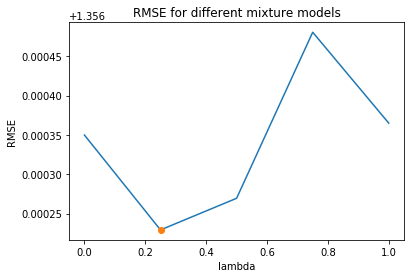

In [49]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

## Tuning for LSI model
- Hyper-paramter: # of topics

In [0]:
def tuning_lsi_param(n_topics,
                     processed, 
                     reviews, 
                     business):
  rmse_lsi = []

  reviews_processed = get_review_processed(processed, reviews)
  uid_sample = reviews_processed['user_id'].values
  bid_sample = reviews_processed['business_id'].values

  for n_topic in n_topics:
    predictions_lsi, actual_lsi = [], []
    for i in range(len(reviews_processed)):
      act, pred = get_results_lsi(processed, 
                                  reviews_processed, 
                                  business, 
                                  bid_sample[i], 
                                  uid_sample[i], 
                                  5,
                                  n_topic)
      predictions_lsi.append(pred)
      actual_lsi.append(act)
    
    rmse = mean_squared_error(predictions_lsi, actual_lsi)**0.5
    print(rmse)
    rmse_lsi.append(rmse)
  
  return rmse_lsi

In [0]:
sample_t = df_btext.sample(n=500, replace=False, random_state=1)\
                   .reset_index()\
                   .drop(columns=['index'])

processed_t = get_processed(sample_t)
n_topics = [10,30,50,80]

In [70]:
rmse_lsi_tune = tuning_lsi_param(n_topics,
                                 processed_s, 
                                 reviews, 
                                 business)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.44652844339635483


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.44605640676934855


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.44605640676934855


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.44605640676934855


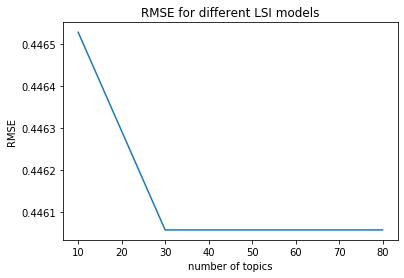

In [90]:
plt.plot(n_topics, rmse_lsi_tune)
plt.xlabel('number of topics')
plt.ylabel('RMSE')
plt.title('RMSE for different LSI models')
plt.show()

# Evaluation

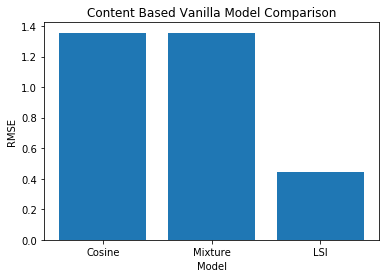

In [0]:
rmse_vanilas = [rmse_cos, rmse_mix, rmse_lsi]
plt.bar(['Cosine', 'Mixture', 'LSI'], rmse_vanilas)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('Content Based Vanilla Model Comparison')
plt.show()

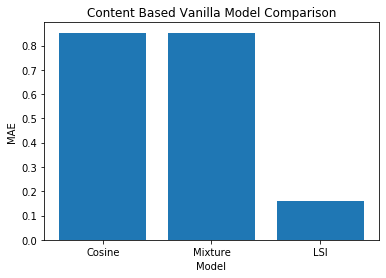

In [0]:
mae_vanilas = [mae_cos, mae_mix, mae_lsi]
plt.bar(['Cosine', 'Mixture', 'LSI'], mae_vanilas)
plt.ylabel('MAE')
plt.xlabel('Model')
plt.title('Content Based Vanilla Model Comparison')
plt.show()

## Active VS Inactive Users

In [106]:
reviews_user = pd.DataFrame(reviews.groupby('user_id')['reviews'].count())
active_users = reviews_user.describe()
threshold = active_users.loc['50%'].values[0]
print(f'the threshold between active and inactive users is {threshold} reviews')
active_users

the threshold between active and inactive users is 10.0 reviews


,reviews
count,63208.000000
mean,18.215242
std,26.583694
min,5.000000
25%,6.000000
50%,10.000000
75%,19.000000
max,854.000000


In [113]:
user_id_active = list(reviews_user.loc[reviews_user['reviews']>=threshold].index)
user_id_inactive = list(reviews_user.loc[reviews_user['reviews']<threshold].index)

print(f'number of active users: {len(user_id_active)}, number of inactive users: {len(user_id_inactive)}')

number of active users: 33315, number of inactive users: 29893


In [0]:
sample_users = df_btext.sample(n=2000, replace=False, random_state=42)\
                        .reset_index()\
                        .drop(columns=['index'])
processed_users = get_processed(sample_users)
reviews_users = get_review_processed(processed_users, reviews)

In [0]:
reviews_active_users = reviews_users.loc[reviews_users.user_id.isin(user_id_active)]
reviews_inactive_users = reviews_users.loc[reviews_users.user_id.isin(user_id_inactive)]
limit = min(reviews_active_users.shape[0], reviews_inactive_users.shape[0])
reviews_active_users = reviews_active_users.iloc[:limit]
reviews_inactive_users = reviews_inactive_users.iloc[:limit]

In [0]:
rmse_active = tuning_mix_param([0.2], processed_users, reviews_active_users, business)
rmse_inactive = tuning_mix_param([0.2], processed_users, reviews_inactive_users, business)

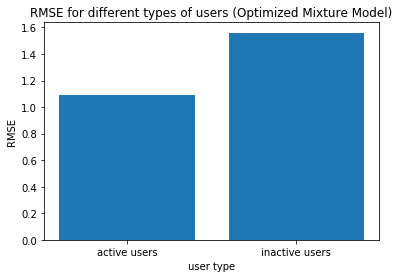

In [142]:
plt.bar(['active users', 'inactive users'], [rmse_active[0], rmse_inactive[0]])
plt.xlabel('user type')
plt.ylabel('RMSE')
plt.title('RMSE for different types of users (Optimized Mixture Model)')
plt.show()

In [143]:
rmse_active_lsi = tuning_lsi_param([30], processed_users, reviews_active_users, business)
rmse_inactive_lsi = tuning_lsi_param([30], processed_users, reviews_inactive_users, business)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.29468059646815353


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.3062441602749151


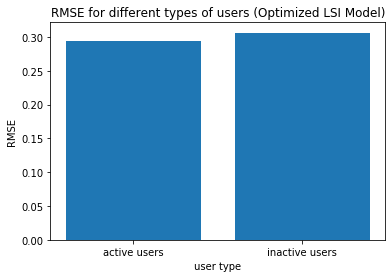

In [144]:
plt.bar(['active users', 'inactive users'], [rmse_active_lsi[0], rmse_inactive_lsi[0]])
plt.xlabel('user type')
plt.ylabel('RMSE')
plt.title('RMSE for different types of users (Optimized LSI Model)')
plt.show()

# Popular VS Unporpular Business

In [0]:
sample_business = pd.merge(sample_users, business, how='left', on='business_id')[['business_id', 'reviews', 'review_count']]

In [179]:
business_count = pd.DataFrame(sample_business.groupby('business_id')['review_count'].sum())
business_stats = business_count.describe()
threshold_business = business_stats.loc['50%'].values[0]
print(f'the threshold between popular and unpopular businesses is {threshold_business} reviews')
business_stats

the threshold between popular and unpopular businesses is 14.0 reviews


,review_count
count,2000.000000
mean,45.180000
std,115.503182
min,3.000000
25%,6.000000
50%,14.000000
75%,37.000000
max,1793.000000


In [181]:
busi_id_pop = list(business_count.loc[business_count['review_count']>=threshold_business].index)
busi_id_unpop = list(business_count.loc[business_count['review_count']<threshold_business].index)

print(f'number of active users: {len(busi_id_pop)}, number of inactive users: {len(busi_id_unpop)}')

number of active users: 1018, number of inactive users: 982


In [0]:
sample_business_pop = sample_business.loc[sample_business.business_id.isin(busi_id_pop)]
sample_business_unpop = sample_business.loc[sample_business.business_id.isin(busi_id_unpop)]

In [0]:
processed_bpop = get_processed(sample_business_pop)
processed_bunpop = get_processed(sample_business_unpop)

In [0]:
reviews_bpop = get_review_processed(processed_bpop, reviews)
reviews_bunpop = get_review_processed(processed_bunpop, reviews)

In [0]:
rmse_pop = tuning_mix_param([0.2], processed_bpop, reviews_bpop, business)
rmse_unpop = tuning_mix_param([0.2], processed_bunpop, reviews_bunpop, business)

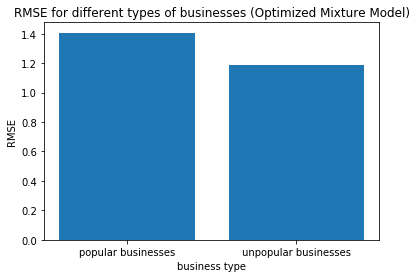

In [186]:
plt.bar(['popular businesses', 'unpopular businesses'], [rmse_pop[0], rmse_unpop[0]])
plt.xlabel('business type')
plt.ylabel('RMSE')
plt.title('RMSE for different types of businesses (Optimized Mixture Model)')
plt.show()

In [187]:
rmse_pop_lsi = tuning_lsi_param([30], processed_bpop, reviews_bpop, business)
rmse_unpop_lsi = tuning_lsi_param([30], processed_bunpop, reviews_bunpop, business)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5656552637719253


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.3234323199812684


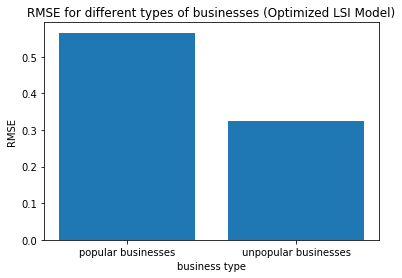

In [188]:
plt.bar(['popular businesses', 'unpopular businesses'], [rmse_pop_lsi[0], rmse_unpop_lsi[0]])
plt.xlabel('business type')
plt.ylabel('RMSE')
plt.title('RMSE for different types of businesses (Optimized LSI Model)')
plt.show()